# Deep Learning Assignment 1

In this assignment:
* We will explore and implement the TripletMargin loss function.
* Write custom Datasets and model classes that are compatible with the TripletMargin loss function. 
* Introduce ResNet blocks
* Visualize the learnign objective of TripletMargin loss
* Write a classifier model to work on top of a embedding model



# TripletMarginLoss

TripletMargin loss was first introduces for face recoginition in 2015 by some google researchers in their paper [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf).

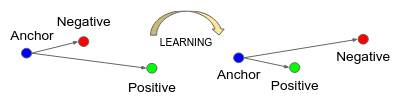

In short triplet margin loss works on a triple consisting of an anchor data, positive data and negative data. The loss function moves the postive data close to the anchor data while seperating the negative data from the anchor data.
**Triplet Loss encourages that dissimilar pairs be distant from any similar pairs by at least a certain margin value.**

# Resources

https://arxiv.org/pdf/1503.03832.pdf

https://towardsdatascience.com/triplet-loss-advanced-intro-49a07b7d8905

https://en.wikipedia.org/wiki/Triplet_loss

https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html



# General instructions

* This assignment is due on 28th Feb 2023, 23:59
* In the notebook it is clearly mentioned where changes have to be made through comments and **[TODO]** markers. However, questions can be asked from any code in this notebook. Therefore, make sure you understand the code in the notebook
* Clearly mention any sources used for answering the questions
* By submitting this assignment solution, you confirm to follow the IITGN's honor code. We shall strictly penalize the submissions containing plagiarized text/code.


# Questions

Explain the functionality of lines marked by the marked "_<--- Question {number}_ " 

Each question carries 0.2 marks

# Answers [0.2 Marks x 10]

#### Write your answers here ###

1. Answer1
 This line, positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label],in the code is used here to get the indices of all other images in the dataset that have the same label as the anchor image. The self.index variable contains the indices of all images in the dataset. self.labels variable contains the labels of all images. this is selecting the indices that are not equal to the anchor image index, and have the same label as the anchor image. It uses boolean mask to select the indices for the label that are equal to the label of the anchor image.

2. Answer2
The function _make_layer() defines in the code _make_layer(), isused to create a residual block in the architecture. the function creates a list of block layers with the appropriate number of input and output channels using the block argument and the palnes and previous_dilation variables. It actually returns a sequential module containing the the list of block.If dilate is True, the dilation is multiplied by the stride and the stride is set to 1. If the stride is not 1 or the input planes and output planes are different, a downsampling layer is created using a 1x1 convolution followed by normalization. the function have normalized several variables: norm_layer(a normalization layer, maybe batchnorm or groupnorm), downsample (is the inout and output dimensions are different), previous_dilation. It evan take several arguments, block(type of block used), planes(number of output channeks for the block), blocks(number of blocks to create in the layer), stride(stride to use for the first block in the layer), dilate(to apply dilation to the blocks or not).

3. Answer3
x=self.avgpool(x) performs average pooling on the input x after passing it through the convolutional layers and the residual blocks. the blocks are the layer1, layer2, layer3, layer4 module. average pooling reduces the spatial dimensions of the input tensor by taking the avg value of every non-overlapping sub region of the input.
In the case of ResNet, the avgpool operation reduces the spatial dimensions of the output of the final residual block to a 1x1 feature map. This 1x1 feature map represents a summary of the most salient features in the input image, which can be used to generate a prediction for a classification task.

4. Answer4
norm_embedding = F.normalize(embedding, p=2, dim=1) is basically performing L2 normalization on the output embedding vector. normalizing the embedding vector is useful for calculating distances between vectors using the Euclidean distance metric.

5. Answer5
 optim.Adam(model.parameters(), lr=0.001) is used to create an instance of the adam optimizer and specifies the parameters that will be optimized. It is taking the parameters of model and lr=0.001 as the input. The optimizer will be used to update the weights of the model during training, based on the gradients of the loss function with respect to the parameters.

6. Answer6
tmp = test_results[labels==label] creates a new numpy array tmp by selecting all rows from test_results that correspond to the images belonging to a particular label. The labels array is an array of the same shape as test_results that specifies the label of each input image.

7. Answer7
 To ensure that the embedding_model is not trained during the training of the Classifier, we can set it to evaluation mode using the eval() method. The same is being done using self.embedding_model.eval().

8. Answer8
loss.backward() is a function that calculate the gradients of the loss w.r.t the parameter of the model that contribute to the loss. It backpropagates the gradients from the output layer of the model through all the layers of the model and updates the gradients of all the parameters, which are stored in their (.grad) attributes.These gradients are then used by an optimizer such as SGD or Adam to update the model's parameters in the direction of steepest descent of the loss

9. Answer9
optimizer.step() is a function that is used for updating the parameters of the model based on the gradients computed in the backward pass. It adjust the parameters by taking a step in the diection of negative gradient w.r.t the current parameter based on the lr and on the any additional hyperparameters such as momentum or weight decay.

10. Answer10
It checks, if the current validation loss is better than the previous best validation loss. if its true, it updates the best_loss value and the best_loss_epoch varialbles. it also stores the current state of the cls_model and optimizer as a dictionary store_data. This is useful in case the training process is interrupted, as we can load the saved state to continue training from where it was left off.

# Import libraries

In [ ]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
from torch.nn import functional as F

# Load CIFAR dataset

In [ ]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

idx_to_class = {}
for c,idx in cifar_trainset.class_to_idx.items():
  idx_to_class[idx] = c
print("index to class mapping: ",idx_to_class)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
index to class mapping:  {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# Plot sample image

Class : automobile
(32, 32, 3)


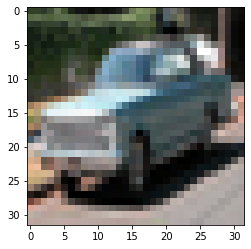

In [ ]:
# Plot
import matplotlib.pyplot as plt
def show_image(image):
  print(image.shape)
  fig = plt.figure
  plt.imshow(image)
  plt.show()

def show_sample(DATA,sample):
  print("Class : {}".format(idx_to_class[DATA.targets[sample]]))
  image = DATA.data[sample]# plot the sample
  show_image(image)



show_sample(cifar_trainset,32)


# Custom Dataset[TODO] [2 Marks]

In [ ]:
class my_CIFAR10(Dataset):
    def __init__(self, cifar_data, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()     #added to convert
        
        self.images = cifar_data.data
        self.labels = np.array(cifar_data.targets)
        self.index = np.array(range(len(self.images)))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item): 
        anchor_img = self.images[item]  # Fill [0.2 Marks]
        anchor_label = self.labels[item] # Fill [0.2 Marks]
        
        if self.is_train:
            # TODO 
           
            positive_list =  self.index[self.index!=item][self.labels[self.index!=item]==anchor_label] # Data Indices which belong to the same label as anchor_image   ## <--- Question 1 [0.3 Marks]
            positive_item = random.choice(positive_list)  # Choose a random item from positive_list [0.1 Marks]
            positive_img  =self.images[positive_item]  # Get the image corresponding to the chosen item [0.1 Marks]
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label] # Data Indices which DO NOT belong to the same label as anchor_image [0.3 Marks]
            negative_item = random.choice(negative_list) # Choose a random item from negative_list [0.1 Marks]
            negative_img  = self.images[negative_item] # Get the image corresponding to the chosen item [0.1 Marks]

            
            if self.transform:

                # Apply transform to all 3 images
                #TODO 
                anchor_img =  self.transform(self.to_pil(anchor_img)) # Fill [0.1 Marks]
                positive_img = self.transform(self.to_pil(positive_img)) # Fill [0.1 Marks]
                negative_img = self.transform(self.to_pil(negative_img))# Fill [0.1 Marks]
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                # Apply transform to anchor_img
                #TODO
                anchor_img = self.transform(self.to_pil(anchor_img)) # Fill [0.1 Marks]
            return anchor_img,anchor_label

In [ ]:
# TODO
# Define the transform for tensor conversion 
# Feel free to experiment with other transforms like Random Cropping .e.t.c
#transform = # Fill here [0.2 Marks]
from torchvision.transforms import ToTensor, Normalize

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
cifar_train_data = my_CIFAR10(cifar_trainset,transform=transform)
cifar_test_data =   my_CIFAR10(cifar_testset,train = False,transform = transform)

In [ ]:
train_size = int(0.8 * len(cifar_train_data))
val_size = len(cifar_train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(cifar_train_data, [train_size, val_size]) 

## Check

If your dataset class is written properly then the following code should show 3 images where the first and second image should belong to the same class whereas the third image should NOT belong to the same class as first and second

torch.Size([32, 32, 3])


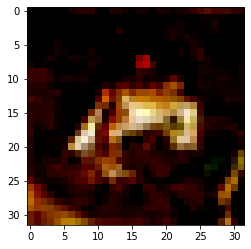

torch.Size([32, 32, 3])


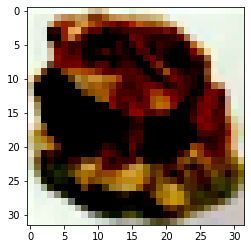

torch.Size([32, 32, 3])


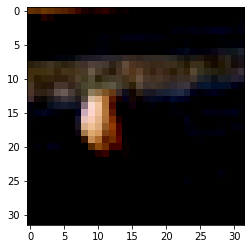

Class of anchor image:  frog


In [ ]:
for anchor_img, positive_img, negative_img, anchor_label in cifar_train_data:
  show_image(anchor_img.permute(1,2,0))
  show_image(positive_img.permute(1,2,0))
  show_image(negative_img.permute(1,2,0))
  print("Class of anchor image: ",idx_to_class[anchor_label])
  break

# Triplet loss [TODO] [2 Marks]

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        # Calculate euclidean distance between x1 and x2
        euc_distance = F.pairwise_distance(x1, x2)
        return euc_distance
    
    def forward(self, anchor, positive, negative):
        # Calculate distances between anchor and positive/negative examples
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        
        # Compute the triplet loss
        losses = F.relu(distance_positive - distance_negative + self.margin)
        
        return losses.mean()

# Resnet

You do not have to make any changes to this code block. However, students are strongly urged to understand the model as Resnet is one of the iconic models in the computer vision landscape

In [ ]:
"""This code was imported from the official PyTorch Torchvision GitHub repository for the purposes doing experiments
    with fine-tuned resnet architectures:
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""

import torch
import torch.nn as nn
# Replaced 'from .utils import load_state_dict_from_url' with the following:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            ) ## <--- Question 2

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x) ## <--- Question 3
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


# Resnet for TripletLoss [TODO] [1 Marks]

In [ ]:
class Resnet18Triplet(nn.Module):
    """Constructs a ResNet-18 model for training using triplet loss.
    Args:
        embedding_dimension (int): Required dimension of the resulting embedding layer that is outputted by the model.
                                   using triplet loss. Defaults to 512.
        pretrained (bool): If True, returns a model pre-trained on the ImageNet dataset from a PyTorch repository.
                           Defaults to False.
    """

    def __init__(self, embedding_dimension=512, pretrained=False):
        super(Resnet18Triplet, self).__init__()
        self.model = resnet18(pretrained=pretrained)

        # modify the last layer to return tensor of embedding_dimension
        input_features_fc_layer = self.model.fc.in_features # Fill here [1 Marks]
        self.model.fc = nn.Linear(input_features_fc_layer, embedding_dimension, bias=False)

    def forward(self, images):
        """Forward pass to output the embedding vector and the embedding vector after l2-normalization"""
        embedding = self.model(images)
        # From: https://github.com/timesler/facenet-pytorch/blob/master/models/inception_resnet_v1.py#L301

        norm_embedding = F.normalize(embedding, p=2, dim=1) ## <--- Question 4
        
        return norm_embedding,embedding

# Set training parameters

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10 # There is no need to run for more epochs than 50
EMB_DIM = 128 # 
NUM_CLASSES = 10

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2,pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2,pin_memory = True)
test_loader = DataLoader(cifar_test_data, batch_size=32, shuffle=False, num_workers=2,pin_memory = True)


# Define the model

In [ ]:
model = Resnet18Triplet(embedding_dimension = 2,pretrained = True) # Changed embedding dimension from 256 --> 2
model.apply(init_weights)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001) ## <--- Question 5
criterion = TripletLoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Train embedding model [TODO] [1 Marks]

In [ ]:
model.train()
best_loss = 1000000
best_loss_epoch = -1
triplet_loss = TripletLoss()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    running_val_loss = []
    
    ## Training
    model.train()
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out,_ = model(anchor_img)
        positive_out,_ = model(positive_img)
        negative_out,_ = model(negative_img)
        
        loss = triplet_loss(anchor_out, positive_out, negative_out) # Fill here [0.4 Marks]
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    
    
    ## Validation 
    model.eval()
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(val_loader, desc="Validation", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        anchor_out,_ = model(anchor_img)
        positive_out,_ = model(positive_img)
        negative_out,_ = model(negative_img)
        
        loss = triplet_loss(anchor_out, positive_out, negative_out) # Fill here [0.4 Marks]
        running_val_loss.append(loss.cpu().detach().numpy())
   
    print("Epoch: {}/{} - Train Loss: {:.4f} Val Loss: {:.4f}".format(epoch+1, epochs,np.mean(running_loss), np.mean(running_val_loss)))
    
    if(np.mean(running_val_loss) < best_loss):
      # Keep track of the best  epoch
      print("Current best loss at epoch: ",epoch+1)
      best_loss_epoch = epoch+1
      best_loss = np.mean(running_val_loss) # Fill here [0.1 Marks]
      store_data = {"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }
    
    

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1/10 - Train Loss: 0.7780 Val Loss: 0.7005
Current best loss at epoch:  1


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2/10 - Train Loss: 0.6862 Val Loss: 0.6847
Current best loss at epoch:  2


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3/10 - Train Loss: 0.6848 Val Loss: 0.6685
Current best loss at epoch:  3


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4/10 - Train Loss: 0.6611 Val Loss: 0.6677
Current best loss at epoch:  4


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5/10 - Train Loss: 0.6395 Val Loss: 0.6465
Current best loss at epoch:  5


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6/10 - Train Loss: 0.6351 Val Loss: 0.6261
Current best loss at epoch:  6


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7/10 - Train Loss: 0.6078 Val Loss: 0.6257
Current best loss at epoch:  7


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8/10 - Train Loss: 0.6463 Val Loss: 0.6609


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9/10 - Train Loss: 0.6205 Val Loss: 0.7140


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10/10 - Train Loss: 0.6120 Val Loss: 0.6702


In [ ]:
# Write code to load the best epoch
# TODO [0.1 Marks]
model.load_state_dict(store_data["model_state_dict"])
optimizer.load_state_dict(store_data["optimzier_state_dict"])

# Plot the results

If the model is trained correctly you should be able to see some level of grouping among embeddings belonging to the same class

In [ ]:
test_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        test_results.append(model(img.to(device))[0].cpu().numpy())
        labels.append(label)
        
test_results = np.concatenate(test_results) 
labels = np.concatenate(labels)
test_results.shape

  0%|          | 0/313 [00:00<?, ?it/s]

(10000, 2)

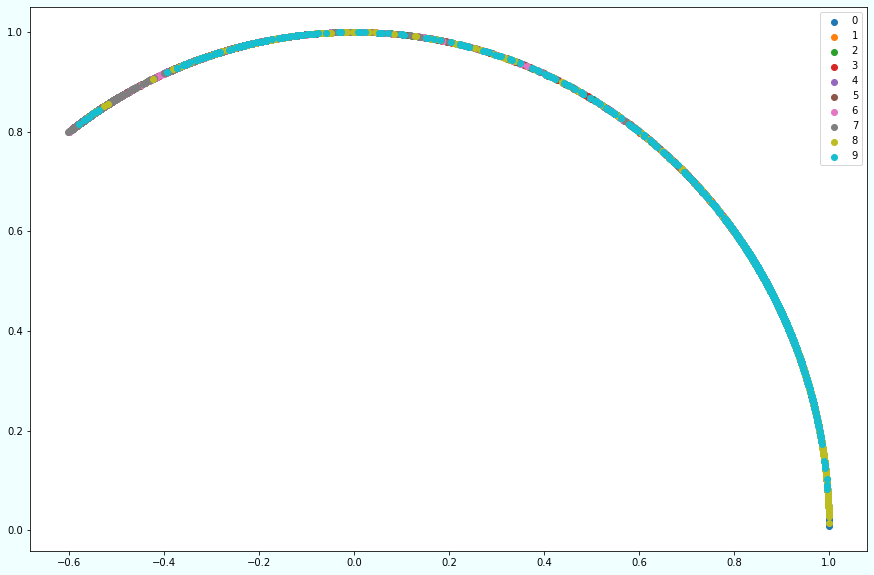

In [ ]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = test_results[labels==label] ## <--- Question 6
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

# Classifier [TODO][0.5 Marks]

In [ ]:
class Classifier(nn.Module):
    """Constructs a simple Classifier MLP head classfiying the embeddings from the previous model into classes
    Args:
        embedding_model:  Trained Resnet18Triplet model
        embedding_dimension (int): Required dimension of the resulting embedding layer that is outputted by the model.
                                   using triplet loss. Defaults to 512.
        num_classes: Number of classes
        device: Device on to which the embedding_model should be loaded. Defaults to cuda
    """

    def __init__(self, embedding_model, num_classes, embedding_dimension=512, device='cuda'):
        super(Classifier, self).__init__()
        # Load the embedding_model on the specified device
        self.embedding_model = embedding_model.to(device)
        self.embedding_model.eval()
        # Create a Linear layer with number_of_input_feats = embedding_dimension and number_of_output_feats = num_classes
        self.classifier = nn.Linear(embedding_dimension, num_classes)

    def forward(self, images):
        """Forward pass to output the embedding vector (feature vector) after l2-normalization."""
        _, embedding = self.embedding_model(images)
        y = self.classifier(embedding)
        return y

# Define the classifier model [TODO][0.5 Marks]

We will use Adam optimizer(LR = 0.001) and cross entropy loss for training the classifier model

In [ ]:
cls_model = Classifier(embedding_model=Resnet18Triplet(), num_classes=10)
cls_model.apply(init_weights)
cls_model = cls_model.to(device)

optimizer = optim.Adam(cls_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Train the classifier model [TODO] [1 Marks]


In [ ]:
  cls_model.train()
  model.eval()
  best_loss = 100000
  best_loss_epoch = -1
  for epoch in tqdm(range(epochs), desc="Epochs"):
      running_loss = []
      running_val_loss = []
      
      # Training
      model.train()
      for step, (inputs, _, _, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
          
          optimizer.zero_grad() # Reset gradients
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = cls_model(inputs)
          loss = criterion(outputs, labels) # Compute loss
          loss.backward() # Compute gradients
          optimizer.step() # Update model parameters
          
          running_loss.append(loss.cpu().detach().numpy())

      # Validation
      model.eval()
      for step, (inputs, _, _, labels) in enumerate(tqdm(val_loader, desc="Validation", leave=False)):
          
          inputs = inputs.to(device)
          labels = labels.to(device)
          with torch.no_grad():
              outputs = cls_model(inputs)
              loss = criterion(outputs, labels)
          
          running_val_loss.append(loss.cpu().detach().numpy())
      print("Epoch: {}/{} - Train Loss: {:.4f} Val Loss: {:.4f}".format(epoch+1, epochs,np.mean(running_loss), np.mean(running_val_loss)))
      
      if(np.mean(running_val_loss) < best_loss):
          print("Current best loss at epoch: ",epoch+1)
          best_loss_epoch = epoch+1
          best_loss = np.mean(running_val_loss)
          store_data = {"model_state_dict": cls_model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict()
                      }


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1/10 - Train Loss: 1.5388 Val Loss: 1.3744
Current best loss at epoch:  1


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2/10 - Train Loss: 1.1827 Val Loss: 1.2338
Current best loss at epoch:  2


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3/10 - Train Loss: 0.9762 Val Loss: 1.1529
Current best loss at epoch:  3


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4/10 - Train Loss: 0.7796 Val Loss: 1.1691


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5/10 - Train Loss: 0.6163 Val Loss: 1.2366


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6/10 - Train Loss: 0.4696 Val Loss: 1.3725


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7/10 - Train Loss: 0.3585 Val Loss: 1.5047


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8/10 - Train Loss: 0.2797 Val Loss: 1.6045


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9/10 - Train Loss: 0.2432 Val Loss: 1.6790


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10/10 - Train Loss: 0.2053 Val Loss: 1.8409


In [ ]:
# Load the best classifier model checkpoint
# Write your code here
# TODO [0.1 Marks]
cls_model.load_state_dict(store_data["model_state_dict"])

<All keys matched successfully>

# Evaluate Prediction accuracy 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = cls_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 61 %


I have tested this results with other values of epochs also and corresponding accuracies are:


epoch 10 : 61%

epoch 50 : 65%

epoch 1 = 50%

epoch 2 : 52%